# **Digital Music Store Analysis**
The "chinook.db" file is a sample database. It contains data about a digital music store. The data related to the media within this database was created using iTunes data.

In [1]:
import sqlite3
import pandas as pd;pd.set_option('display.max_columns', 1000); pd.set_option('display.width', 1000)

db = "C:/Users/aleks/Documents/Data_Analysis/Datasets/chinook_db/chinook.db"

In [2]:
# create run query function
def run_query(query):
    with sqlite3.connect(db) as connection:
        return pd.read_sql(query, connection)

In [3]:
# create database overview function
def overview(database_path):
    with sqlite3.connect(database_path) as connection:
        return pd.read_sql('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");', 
                           connection)

In [4]:
# create table alteration function
def alter_table(query):
    with sqlite3.connect(db) as connection:
        connection.isolation_level = None
        connection.execute(query)

In [5]:
# list tables in database
tables = overview(db)
print(tables)

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


### Which music genres sell the most tracks in the USA? <br>
This can provide an insight into what type of music should be licensed for sale.

In [6]:
# calculated as a total and a percentage value
top_10_genres = run_query("""WITH usa_invoice_lines AS 
                         
                         (
                         SELECT* FROM invoice_line 
                         JOIN invoice ON invoice.invoice_id = invoice_line.invoice_id 
                         WHERE billing_country= 'USA'
                         ),
                         
                         track_genres AS
                         (
                         SELECT track.track_id, genre.* 
                         FROM track JOIN genre on genre.genre_id = track.genre_id
                         ),
                         
                         combo_table AS
                         (
                         SELECT invoice_line_id, invoice_id, track_genres.track_id, 
                         unit_price, invoice_id, billing_country, genre_id, name AS genre 
                         FROM usa_invoice_lines 
                         JOIN track_genres on track_genres.track_id = usa_invoice_lines.track_id
                         )
                         
                         SELECT COUNT(*) as tracks_sold, 
                         ROUND((CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM combo_table))*100,2) as percentage, genre 
                         FROM combo_table 
                         GROUP BY genre 
                         ORDER BY tracks_sold DESC LIMIT 10""")
print(top_10_genres)

   tracks_sold  percentage               genre
0          561       53.38                Rock
1          130       12.37  Alternative & Punk
2          124       11.80               Metal
3           53        5.04            R&B/Soul
4           36        3.43               Blues
5           35        3.33         Alternative
6           22        2.09                 Pop
7           22        2.09               Latin
8           20        1.90         Hip Hop/Rap
9           14        1.33                Jazz


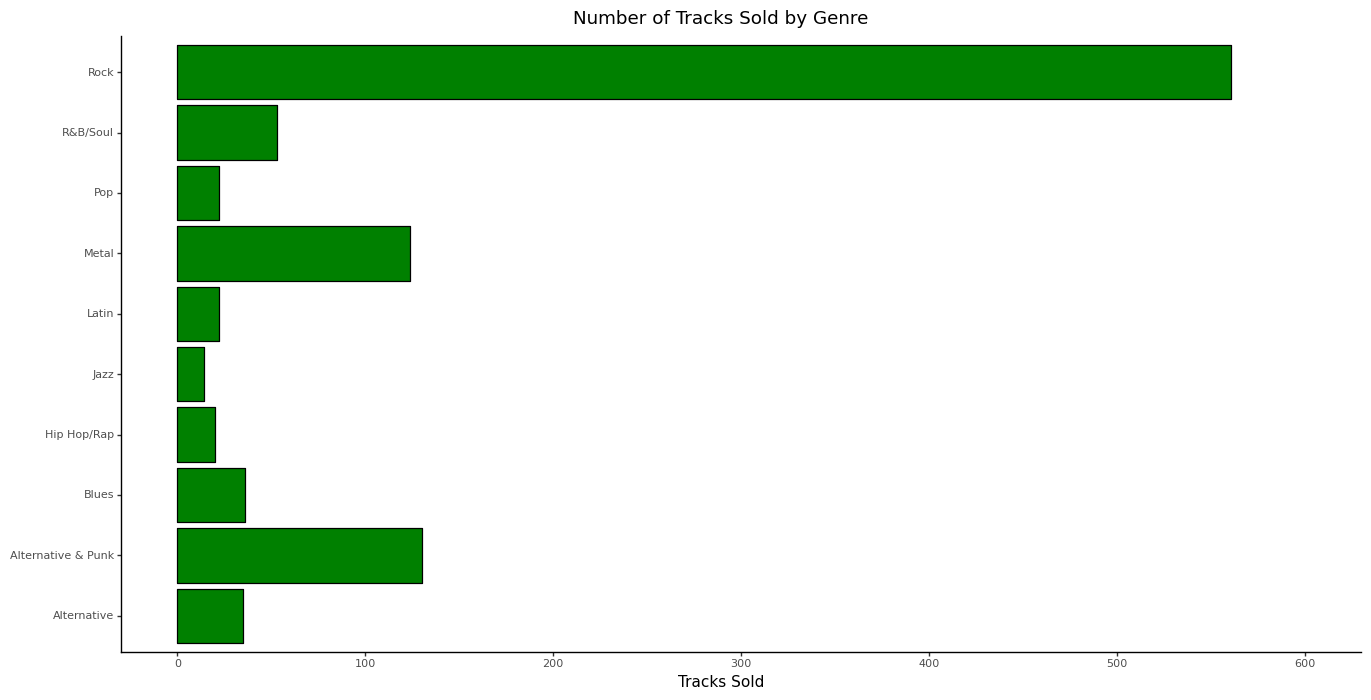

In [536]:
import plotnine as pn

top_10_genres_graph = ggplot(data = top_10_genres, mapping=aes(x= "genre", y= "tracks_sold")) \
+geom_col(fill="green", color="black") \
+coord_flip() \
+labs(title="Number of Tracks Sold by Genre", y= "Tracks Sold") \
+theme_classic() \
+theme(axis_text= element_text(size=8), axis_title_y=element_blank())\
+scale_y_continuous(breaks=(0,100,200,300,400,500,600), limits=(0,600))
print(top_10_genres_graph)

As seen above, it would make sense for the store to add tracks from the "Rock" genre. This is by far the best selling category. Other genres selling well include "Alternative & Punk", "Metal", and "R&B/Soul".

### Which support agents are responsible for the most sales?

In [8]:
# find total sales per salesperson
employee_sales = run_query("""
WITH combo_table AS 
(
SELECT invoice.invoice_id, invoice.total, 
invoice.customer_id, employee.employee_id, employee.first_name as employee_first, 
employee.last_name as employee_last, employee.hire_date, employee.reports_to, employee.country 
FROM invoice 
JOIN customer ON customer.customer_id = invoice.customer_id 
JOIN employee ON employee.employee_id = customer.support_rep_id
) 

SELECT SUM(total) as total_sales, employee_id, employee_first || ' ' || employee_last as name, 
hire_date, reports_to, country 
FROM combo_table 
GROUP BY employee_id 
ORDER BY total_sales DESC""")
print(employee_sales)

   total_sales  employee_id           name            hire_date  reports_to country
0      1731.51            3   Jane Peacock  2017-04-01 00:00:00           2  Canada
1      1584.00            4  Margaret Park  2017-05-03 00:00:00           2  Canada
2      1393.92            5  Steve Johnson  2017-10-17 00:00:00           2  Canada


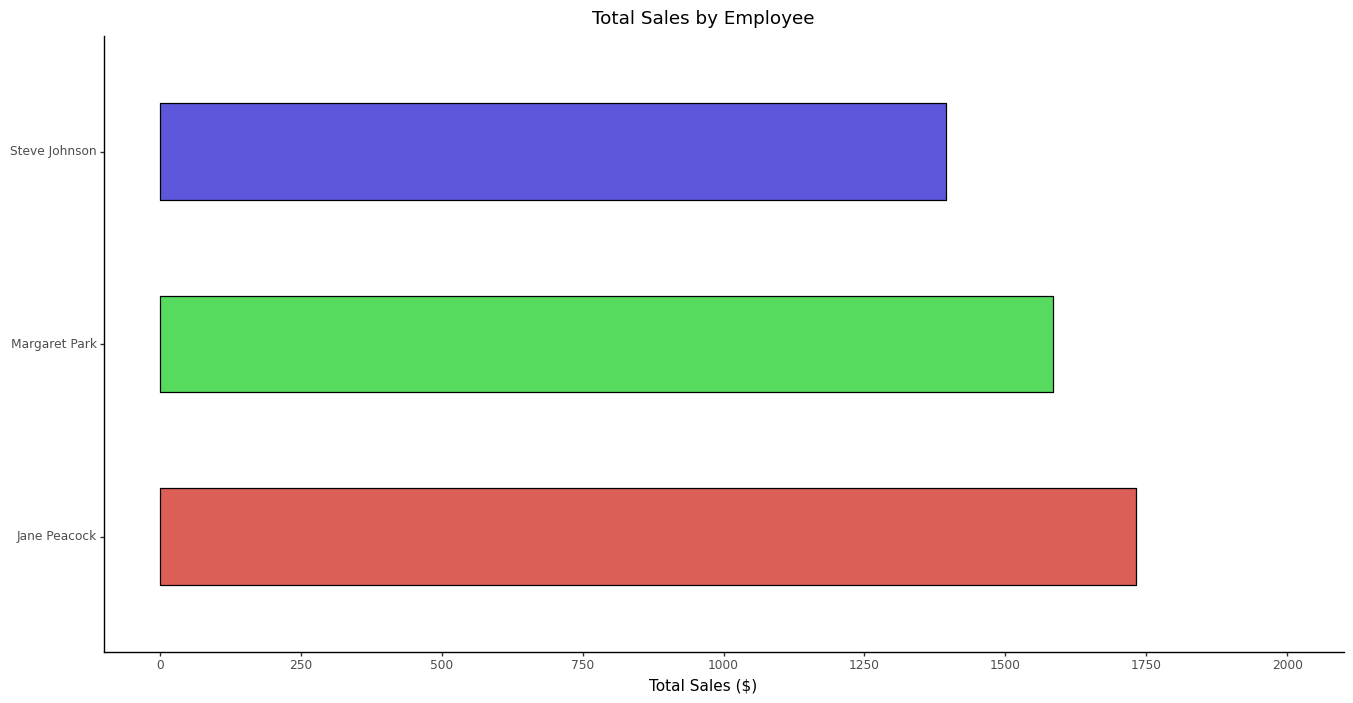

In [538]:
employee_sales_graph = ggplot(data=employee_sales, mapping=aes(x="name", y="total_sales", fill="name")) \
+geom_col(color="black", width=.5) \
+labs(title="Total Sales by Employee", y= "Total Sales ($)") \
+theme_classic() \
+coord_flip() \
+theme(legend_position= "none", axis_title_y=element_blank()) \
+scale_y_continuous(breaks=(0,250,500,750, 1000,1250,1500,1750,2000), limits=(0,2000))
print(employee_sales_graph)

### Do most customers purchase a whole album or individual tracks?

In [268]:
percentage_album_sales = run_query("""
WITH first_invoice_track AS

-- id of the first track for a given invoice id
(
SELECT MIN(track_id) AS first_track_id, invoice_id
FROM invoice_line
GROUP BY invoice_id
),

is_album_table AS

(
SELECT first_invoice_track.*,
    CASE
        WHEN
        
-- given the first track of an invoice, select all the tracks on that album
            (
            
            SELECT track.track_id 
            FROM track 
            WHERE track.album_id = 
            (
            SELECT track.album_id 
            FROM track 
            WHERE track.track_id = first_invoice_track.first_track_id
            )
    
-- given the invoice id, select the tracks on that invoice
            EXCEPT
            SELECT invoice_line.track_id
            FROM invoice_line
            WHERE invoice_line.invoice_id = first_invoice_track.invoice_id
            
            ) IS NULL
            
           AND

           (
           
           SELECT invoice_line.track_id
            FROM invoice_line
            WHERE invoice_line.invoice_id = first_invoice_track.invoice_id
           
           EXCEPT
           
            SELECT track.track_id 
            FROM track 
            WHERE track.album_id = 
            (
            SELECT track.album_id 
            FROM track 
            WHERE track.track_id = first_invoice_track.first_track_id
            )
           
           ) IS NULL
           
            THEN 'YES'
            ELSE 'NO'
        END AS 'is_album'
        
FROM first_invoice_track
)

SELECT 
    COUNT(invoice_id) as total, 
        ROUND((COUNT(invoice_id) / 
        CAST((SELECT COUNT(invoice_id) FROM is_album_table) AS FLOAT))*100,2) as percent,
    is_album
FROM is_album_table
GROUP BY is_album

""")


print(percentage_album_sales)

   total  percent is_album
0    500    81.43       NO
1    114    18.57      YES


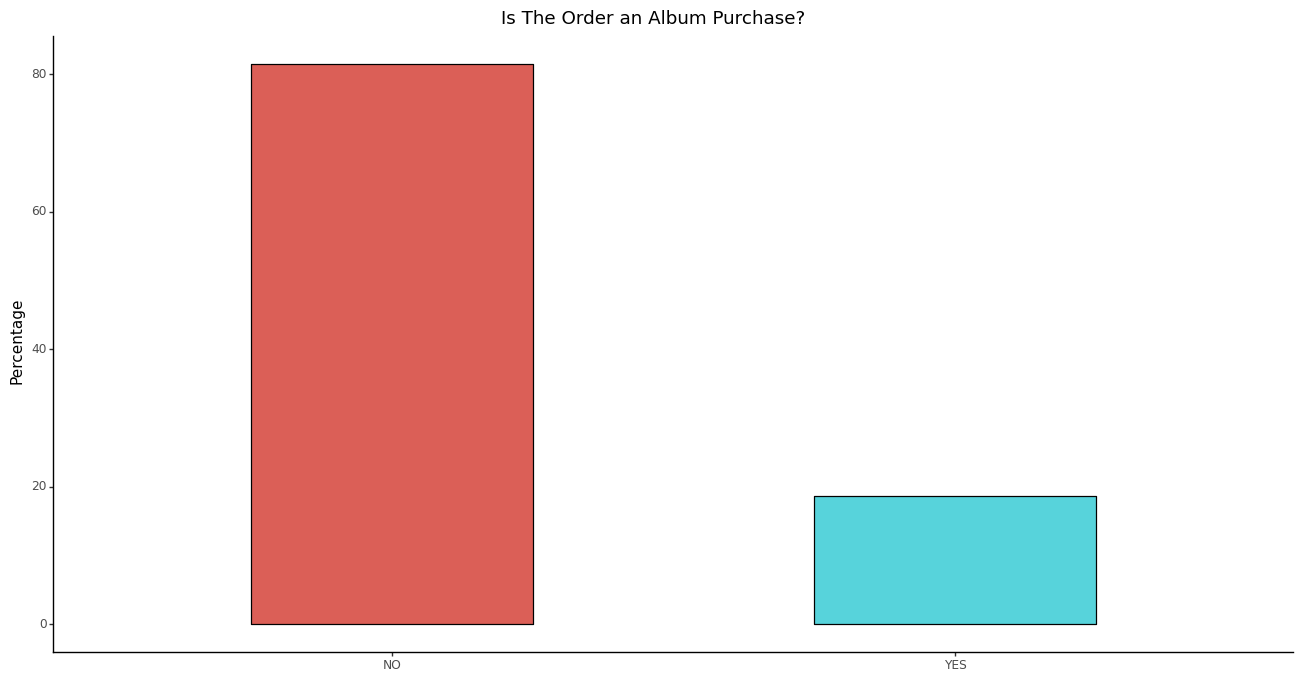

In [554]:
percentage_album_sales_chart = ggplot(percentage_album_sales, aes(x="is_album", y="percent", 
                                                                  fill="is_album")) \
+geom_col(color="black", width=0.5) \
+theme_classic() \
+theme(legend_position= "none", axis_title_x=element_blank()) \
+labs(title= "Is The Order an Album Purchase?", y="Percentage")

print(percentage_album_sales_chart)

Over 80% of invoices are composed of individual tracks. Less than 20% of purchases are whole albums. If the company wanted to save money, it could focus on purchasing the rights to specific tracks instead of entire albums.

### How are sales distributed by country?

In [486]:
#count total customers
by_country= run_query("""

WITH invoices_country AS
(
SELECT country, c.customer_id, c.first_name, c.last_name, invoice_id, total
FROM customer AS c
JOIN invoice AS i
ON i.customer_id = c.customer_id
),

top_countries_only AS
(
SELECT 
    invoices_country.*,
    CASE
        WHEN (SELECT COUNT(*) FROM customer WHERE country = invoices_country.country) <2
        THEN "Other"
    ELSE invoices_country.country
    END AS new_country

FROM invoices_country

),

final_table AS

(

SELECT 
    new_country AS country, 
    COUNT(DISTINCT customer_id) AS unique_customers,
    COUNT(invoice_id) as num_orders,
    SUM(total) AS total_sales,
    ROUND(( SUM(total) / COUNT(DISTINCT customer_id) ),2) AS average_sales_per_customer,
    ROUND(AVG(total),2) AS average_order_total,
    CASE
        WHEN new_country = "Other" THEN 1
        ELSE 2
    END AS sorting
FROM top_countries_only
GROUP BY new_country
ORDER BY sorting DESC, unique_customers DESC
),

final_table_2 AS

(
SELECT 
country, 
unique_customers, 
(unique_customers /  CAST((SELECT SUM(unique_customers) FROM final_table) AS FLOAT))*100
AS pct_total_customers, 
total_sales,
(total_sales /  CAST((SELECT SUM(total_sales) FROM final_table) AS FLOAT))*100
AS pct_total_sales,
average_sales_per_customer, 
average_order_total
FROM final_table
)

SELECT 
country, 
unique_customers,
total_sales,
(pct_total_sales - pct_total_customers) AS sales_to_customer_pct_diff,
average_sales_per_customer, 
average_order_total
FROM final_table_2

""")
print(by_country)

          country  unique_customers  total_sales  sales_to_customer_pct_diff  average_sales_per_customer  average_order_total
0             USA                13      1040.49                    0.059858                       80.04                 7.94
1          Canada                 8       535.59                   -2.186608                       66.95                 7.05
2          Brazil                 5       427.68                    0.606778                       85.54                 7.01
3          France                 5       389.07                   -0.213067                       77.81                 7.78
4         Germany                 4       334.62                    0.325657                       83.66                 8.16
5  United Kingdom                 3       245.52                    0.128624                       81.84                 8.77
6  Czech Republic                 2       273.24                    2.412146                      136.62              

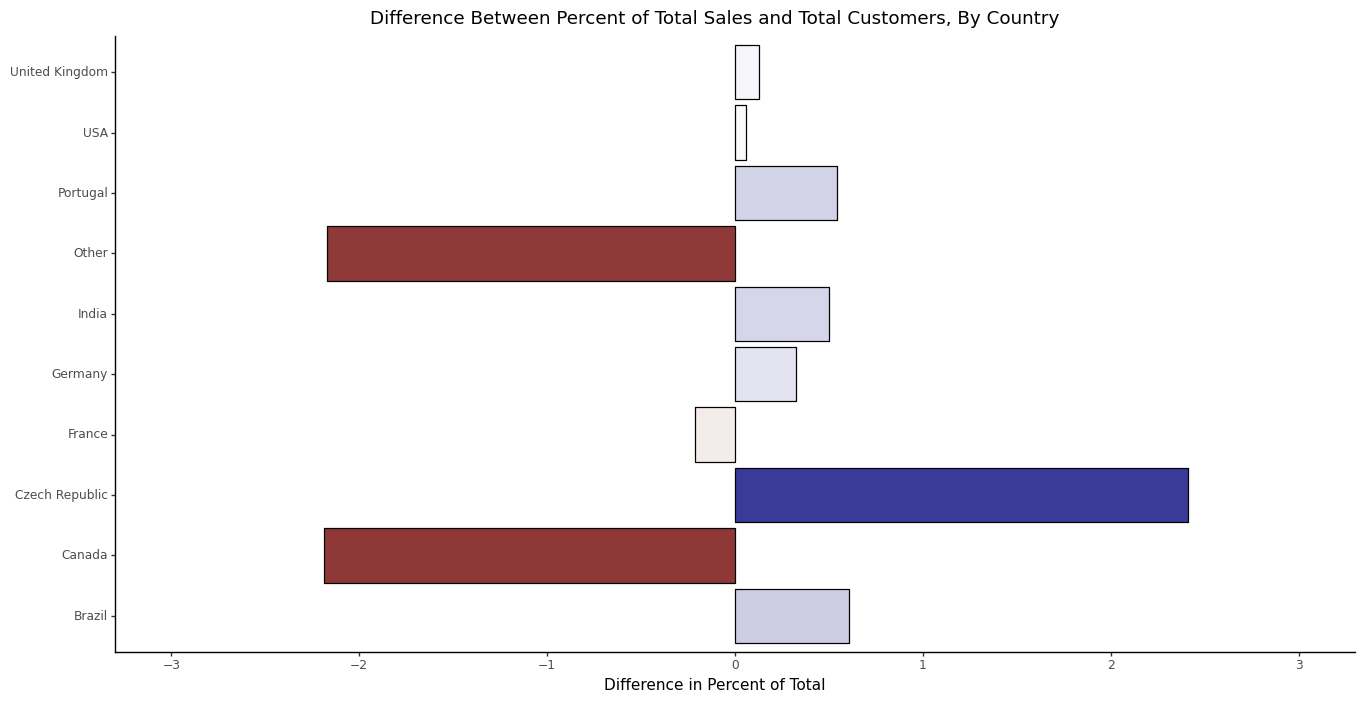

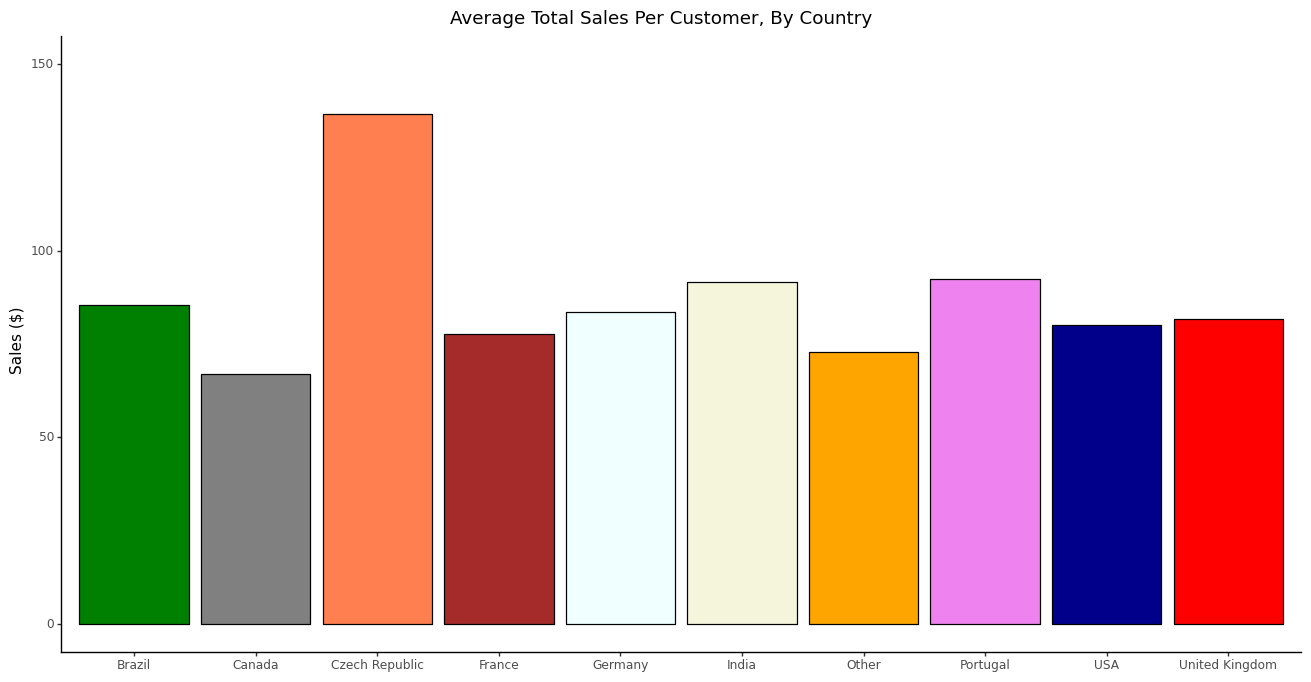

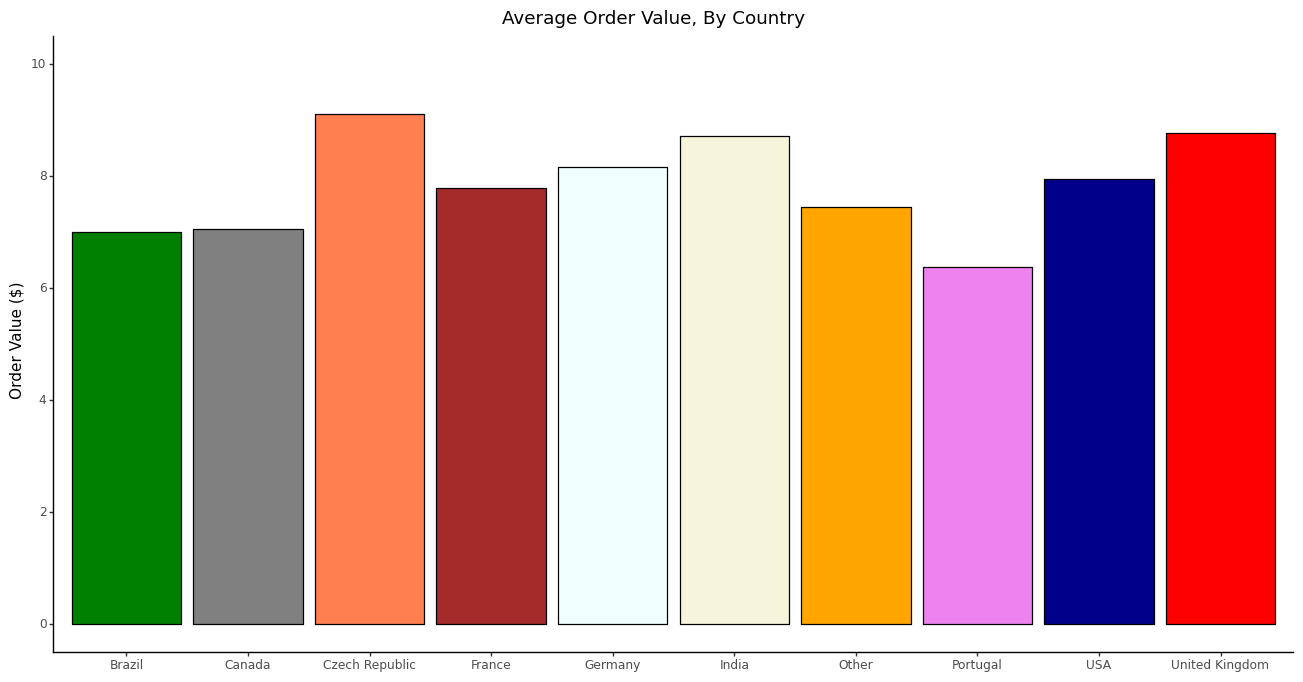

In [572]:
by_country_sales= ggplot(data= by_country, mapping=aes(x="country", y="sales_to_customer_pct_diff", fill="sales_to_customer_pct_diff")) \
+geom_col(color="black") \
+theme_classic() \
+theme(legend_position= "none", axis_title_y=element_blank()) \
+labs(title= "Difference Between Percent of Total Sales and Total Customers, By Country" \
      , y= "Difference in Percent of Total") \
+scale_y_continuous(breaks=(-3,-2,-1,0,1,2,3), limits=(-3,3)) \
+scale_fill_gradient2() \
+coord_flip()

color_dict = {'United Kingdom': 'red', 
              'USA': 'darkblue', 
              'Portugal': 'violet', 
              'Other': 'orange', 
              'India': 'beige', 
              'Germany':'azure',
              'France' :'brown',
              'Czech Republic' :'coral',
              'Canada': 'gray',
              'Brazil': 'green'}

by_country_avg_customer_sales = ggplot(data= by_country, mapping=aes(x="country", 
                                                                     y="average_sales_per_customer",
                                                                     fill="country")) \
+geom_col(color="black") \
+theme_classic() \
+scale_fill_manual(values=color_dict) \
+theme(legend_position= "none", axis_title_x=element_blank()) \
+labs(title="Average Total Sales Per Customer, By Country", y="Sales ($)") \
+scale_y_continuous(breaks=(0,50,100,150), limits=(0,150)) \

by_country_avg_order= ggplot(data= by_country, mapping=aes(x="country", y="average_order_total",
                                                           fill="country")) \
+geom_col(color="black") \
+theme_classic() \
+scale_fill_manual(values=color_dict) \
+theme(legend_position= "none", axis_title_x=element_blank()) \
+labs(title="Average Order Value, By Country", y="Order Value ($)") \
+scale_y_continuous(breaks=(0,2,4,6,8,10), limits=(0,10)) 


print(by_country_sales)
print(by_country_avg_customer_sales)
print(by_country_avg_order)

Based on the visualizations above, there are a few countries that present themselves as opportunities. Czech Republic in particular represents a larger proportion of total sales compared to their proportion of total customers. Portugal, Brazil, and India also fall in to this category, albeit to a lesser degree. This can again be seen in the second graph, indicating that the average total spending of a customer from these countries is above the average.

From the third graph one can see that the Canadian customer, despite underperforming their percentage of total customers when it comes to sales, spends near the norm when they do make a purchase. Conversely, a customer from Portugal seems to spend more than the average in total but does so with more numerous and relatively smaller orders. 

The United Kingdom is another country showing some potential. The average order value is high however this country does not seem to be making many orders at the moment. Investing in this country could have good returns if more frequent orders can be achieved.